In [ ]:
import pandas as pd #для работы с таблицами
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from datetime import datetime #для работы с временем
from sklearn.preprocessing import LabelEncoder, StandardScaler #для обработки данных

In [ ]:
def process(data):
  #делаем из столбца даты рождения столбец возраст и удаляем дату рождения
  data['age'] = data['dob'].apply(lambda x: (datetime.today() - pd.to_datetime(x)).days // 365)
  del data['dob']
  #делаем из столбца даты времени транзакции в отдельные столбцы год, месяц, день, день недели час
  data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
  data['year'] = data['trans_date_trans_time'].dt.year
  data['month'] = data['trans_date_trans_time'].dt.month
  data['day'] = data['trans_date_trans_time'].dt.day
  data['dow'] = data['trans_date_trans_time'].dt.dayofweek
  data['hour'] = data['trans_date_trans_time'].dt.hour
  #удаляем мусор и столбцы не несущие смысловой нагрузки для моделей: номер транзакции, время по юниксу, улица, город, страна пересекаются по смыслу с ZIP - кодом
  del data['trans_date_trans_time']
  del data['Unnamed: 0']
  del data['trans_num']
  del data['unix_time']
  del data['street']
  del data['city']
  del data['state']
  #отделяем столбцы с категориальными переменными
  categorical = ['cc_num',
                 'merchant',
                 'category',
                 'first',
                 'last',
                 'gender',
                 'zip',
                 'job']
  #отделяем датафрейм состоящий только из категориальных столбцов и применяем к ним энкодинг (заменяем категории на цифры)
  cat_processed = pd.concat([pd.DataFrame(LabelEncoder().fit_transform(data[i]), columns = [i]) for i in categorical], axis = 1)

  #отделяем столбцы с численными переменными
  numerical = ['age',
               'amt', 
               'lat',
               'long',
               'city_pop',
               'merch_lat',
               'merch_long']
  #отделяем датафрейм состоящий только из численных столбцов и применяем к ним нормализацию (для ускорения вычислений заменяем значения в столбцы так, чтобы они варьировались от -1 до 1)
  num_processed = pd.concat([pd.DataFrame(StandardScaler().fit_transform(data[i].values.reshape(-1,1)), columns = [i]) for i in numerical], axis = 1)

  #отделяем столбцы которые не нужно изменять
  leave = ['year',
           'month',
           'dow',
           'hour']
  #соединяем все столбцы в один
  data = pd.concat([num_processed, cat_processed, data[leave], data['is_fraud']],
                    axis = 1)

  
                 
  return(data)

In [ ]:
train = pd.read_csv('fraudTrain.csv.zip')
test = pd.read_csv('fraudTest.csv.zip')

In [ ]:
#описание столбцов и их типов данных
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
#описательная статистика данных
train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
#проверяем пропуски
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

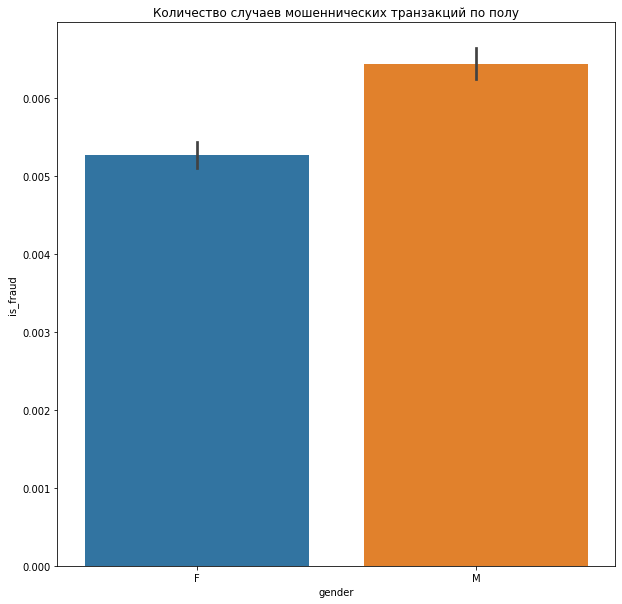

In [ ]:
#сколько мошенничества по каждому полу
plt.figure(figsize=(10,10))
plt.title('Количество случаев мошеннических транзакций по полу')
sns.barplot(x = 'gender', y = 'is_fraud', data = train)

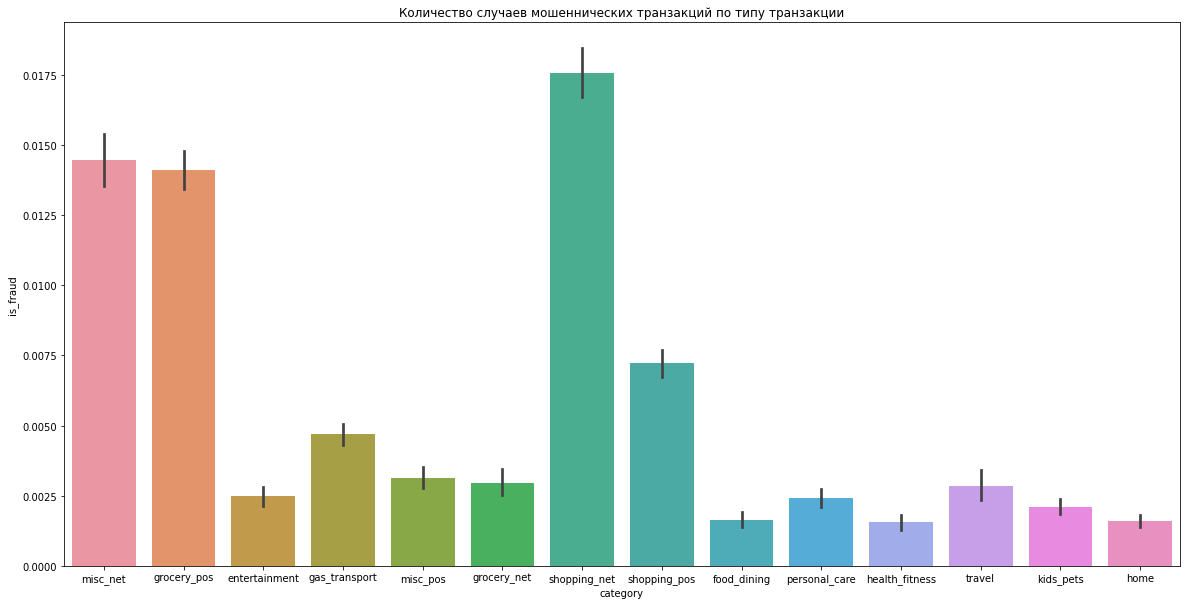

In [ ]:
#сколько мошенничества по типам транзакций
plt.figure(figsize=(20,10))
plt.title('Количество случаев мошеннических транзакций по типу транзакции')
sns.barplot(x="category", y='is_fraud', data= train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


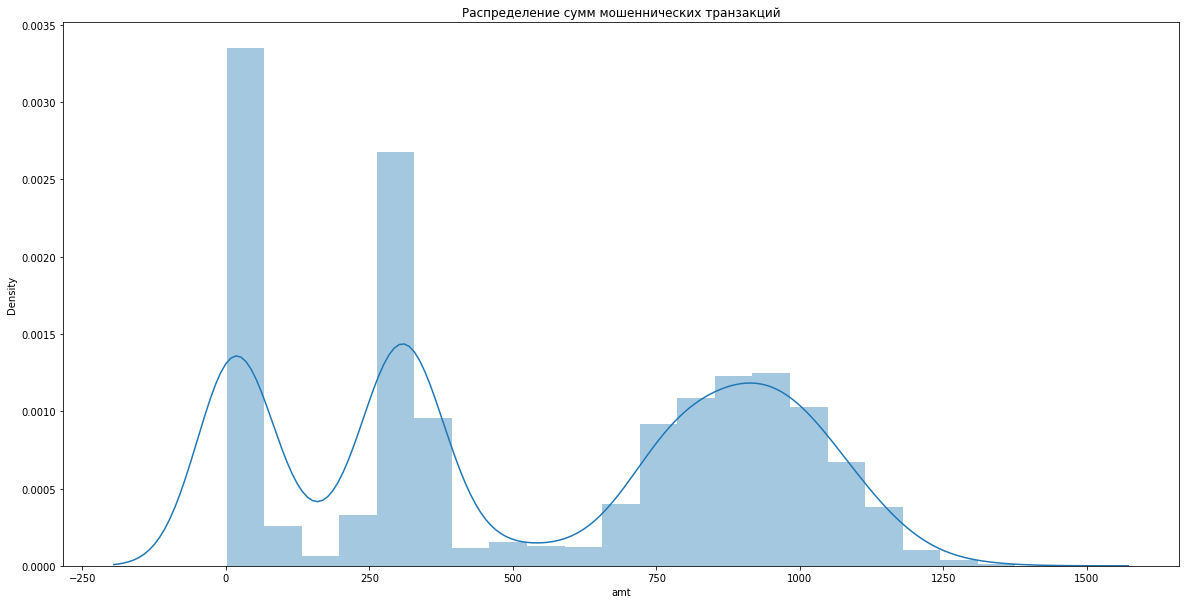

In [ ]:
#распределение сумм мошенничества
plt.figure(figsize=(20,10))
plt.title('Распределение сумм мошеннических транзакций')
sns.distplot(train[train['is_fraud'] == 1]['amt'])

In [ ]:
#обрабатываем данные
train = process(train)
test = process(test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


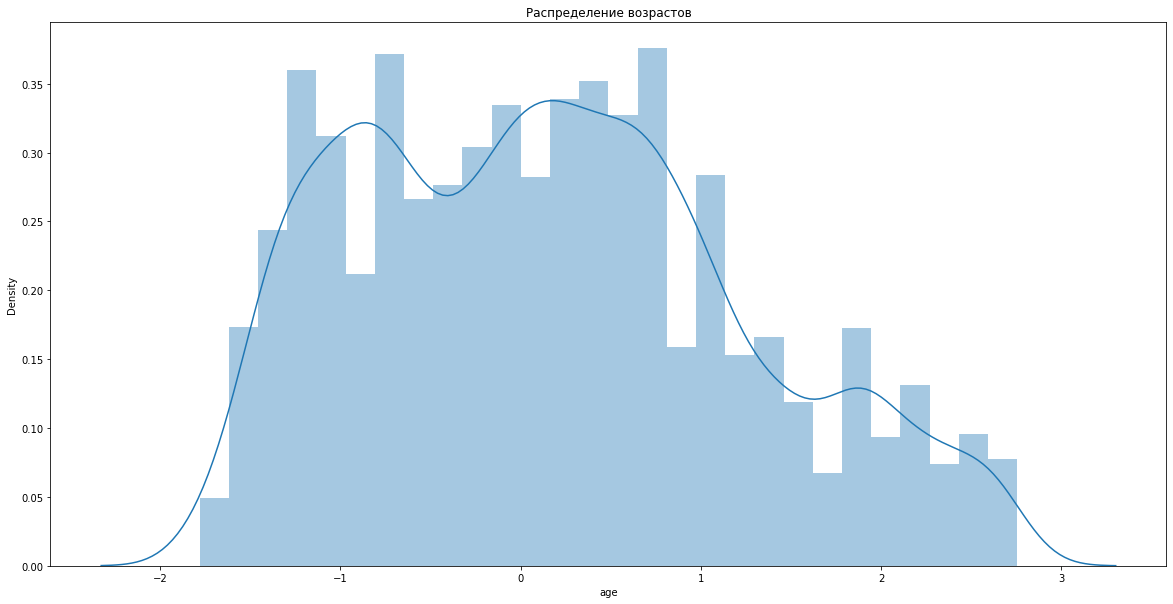

In [ ]:
#распределение возрастов людей которые подверглись мошенничеству
plt.figure(figsize=(20,10))
plt.title('Распределение возрастов')
sns.distplot(train[train['is_fraud'] == 1]['age'])

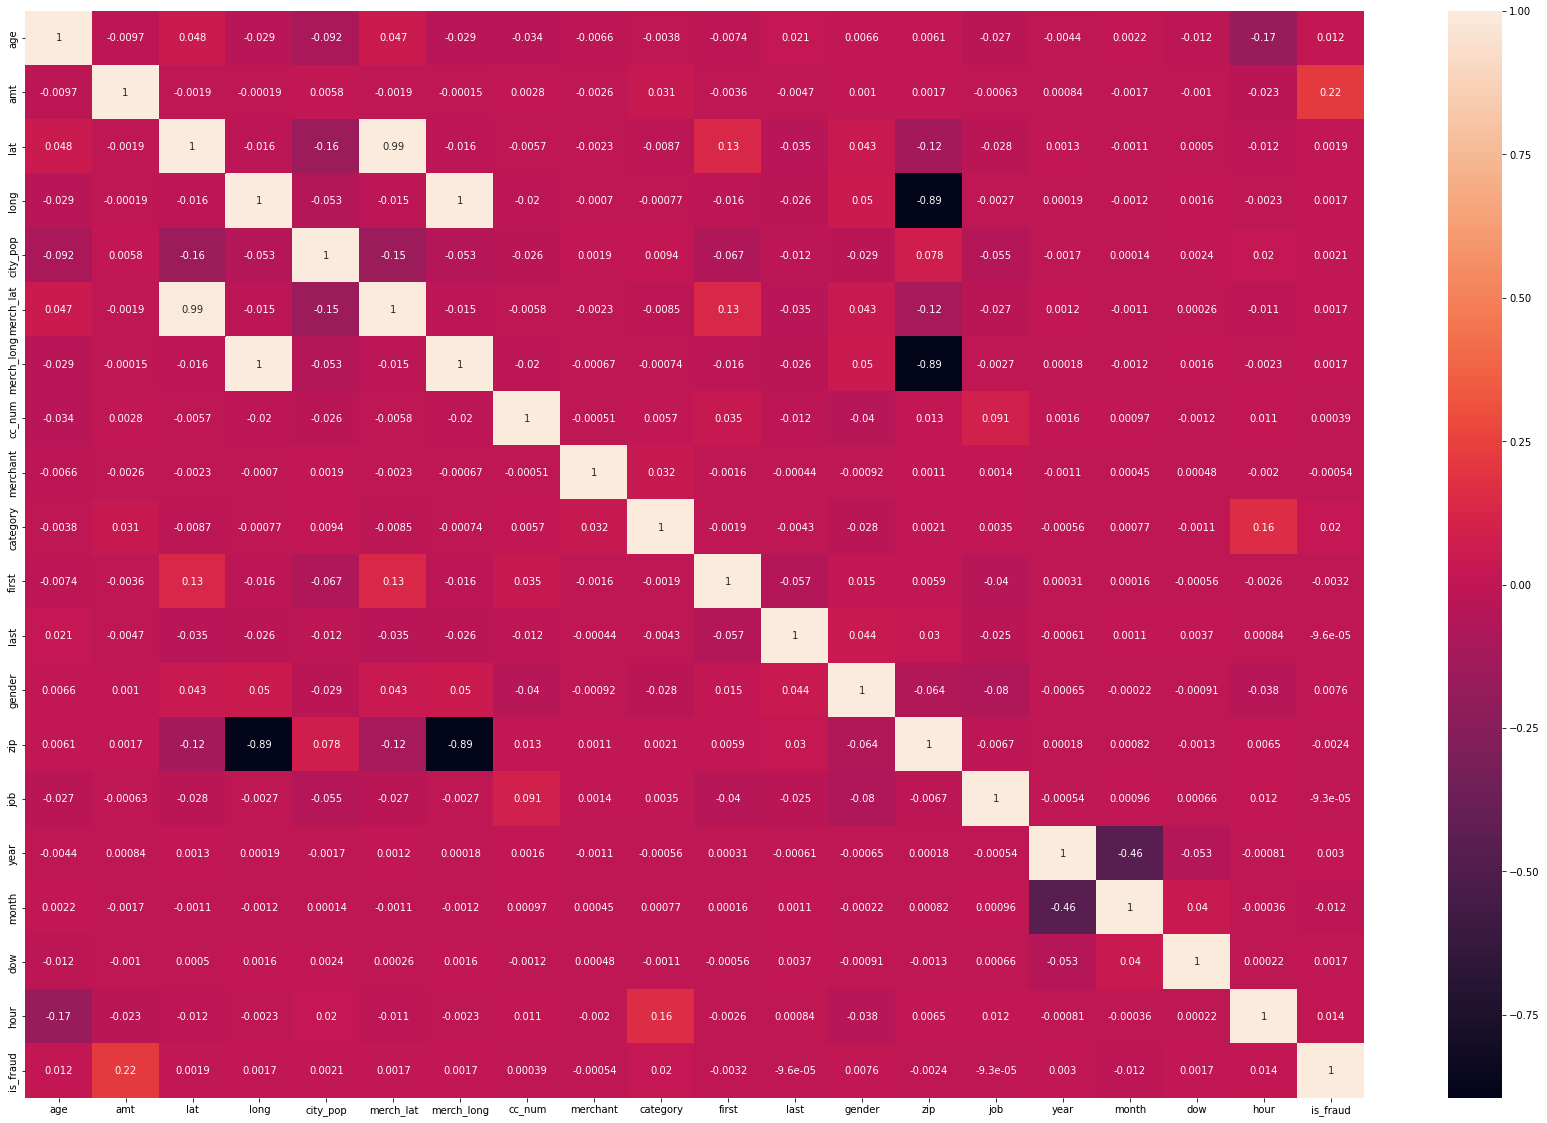

In [ ]:
#матрица корреляций для проверки свзяей между значениями
plt.figure(figsize=(30,20))
sns.heatmap(train.corr(), annot = True)

In [ ]:
from imblearn.over_sampling import SMOTE #для оверсамплинга
from sklearn.metrics import * #метрики 
xc = train.columns[:len(train.columns)-1] #отделяем столбцы X
yc = train.columns[-1] #отделяем столбец Y
x, y = SMOTE().fit_resample(train[xc], train[yc]) #применяем сэмплинг

In [ ]:
y.value_counts() #смотрим количество значений после сэмплинга

0    1289169
1    1289169
Name: is_fraud, dtype: int64

In [ ]:
# функция для обучения и оценки любой модели
def asses(model):
  m = model # иницализируется модель поданная на вход функции
  m.fit(x, y) # обучается на x и y
  plot_confusion_matrix(m, test[xc], test[yc]) # строим матрицу ошибок


[08:47:27] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


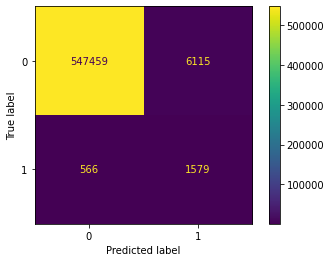

In [ ]:
asses(xgb.XGBClassifier(tree_method='gpu_hist',
                        use_label_encoder=False,
                        eval_metric = 'logloss',
                        max_bin = 16,
                        predictor = 'gpu_predictor',
                        nthread = 2,
                        n_gpus = 1))

In [ ]:
!pip install -U xgboost #устанавливем XGBoost алгоритм поддерживающий ускорение на видеокарте
!pip install catboost
!pip install lightgbm --install-option=--gpu
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tqdm.auto import tqdm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb #для XGBoost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)


In [ ]:
for i in tqdm([KNeighborsClassifier(),
              GaussianNB(),
              DecisionTreeClassifier(),
              SVC(),
              xgb.XGBClassifier(tree_method='gpu_hist',
                        use_label_encoder=False,
                        eval_metric = 'logloss',
                        max_bin = 16,
                        predictor = 'gpu_predictor',
                        nthread = 2,
                        n_gpus = 1),
              CatBoostClassifier(verbose=False),
              LGBMClassifier()]):
  asses(i)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
